# Binary classification of movie reviews
---

Binary classification, is one of the most common kinds of machine learning problems. In this example, you’ll learn to classify movie reviews as positive or negative, based on the text content of the reviews.

## The IMDB dataset

You’ll work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.This enables us to focus on model building, training, and evaluation.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# this module has the imdb data set
from tensorflow.keras.datasets import imdb

import numpy as np
import matplotlib.pyplot as plt

### Load and visualize the data set 

The argument num_words=10000 means you’ll only keep the top 10,000 most fre-
quently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size. If we didn’t set this limit, we’d be working with 88,585 unique words in the training data, which is unnecessarily large.

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 0s 0us/step


The variables train_data and test_data are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [3]:
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

print(train_data[0])
print(train_labels[0])

Train data shape: (25000,)
Train labels shape: (25000,)
Test data shape: (25000,)
Test labels shape: (25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 1

To decode a review, we need the dictionary of the words, and then we need to decode the review using it.

In [4]:
word_index = imdb.get_word_index()
reverse_words = {value: key for (key, value) in word_index.items()}

#  Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_words.get(i-3, '?') for i in train_data[0]])

print(decoded_review)

1654784/1641221 [==============================] - 0s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

In [5]:
print(train_labels[:10])

[1 0 0 1 0 0 1 0 1 0]


### Define a function to vectorize the input data

You can’t directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors.

We will Multi-hot encode the lists to turn them into vectors of 0s and 1s. This would mean turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then we'll use a Dense layer, capable of handling floating-point vector data, as the
first layer in your model.

In [6]:
def vectorize_sequences(sequences, dimension=10000):

  results = np.zeros((len(sequences), dimension))

  for i, sequence in enumerate(sequences):
    results[i][sequence] = 1

  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("Sample data:")
print(x_train)
print(x_train.shape)

Sample data:
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
(25000, 10000)


Since the label are already rows with 0 and 1, we only need to turn them to numpy arrays.

In [7]:
y_train = np.array(train_labels).astype("float32")
y_test = np.array(test_labels).astype("float32")

### Define and compile the model

The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you’ll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers. There are two key architecture decisions to be made about such a stack of Dense layers:
- How many layers to use
- How many hidden units to choose for each layer

In [26]:
model = models.Sequential()

model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.SGD(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                160016    
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


The intermediate layers use relu as their activation function, and the final layer uses a sigmoid activation so as to output a probability. A relu (rectified linear unit) is a function meant to zero out negative values, whereas a sigmoid “squashes” arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability.

The relu activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

The vanishing gradient problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training

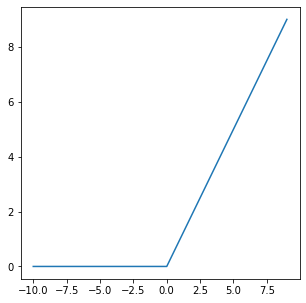

In [9]:
relu_values = np.array([[x, max(x, 0)] for x in range(-10, 10)])

plt.figure(figsize=(5,5)) 
plt.plot(relu_values[:, 0], relu_values[:, 1])
plt.show()

### Validating the model

In order to monitor during training the accuracy of the model on data it has never seen before, we create a validation set by setting apart 10,000 samples from the original training data.

In [10]:
x_val = x_train[15000:]
y_val = y_train[15000:]

partial_x_train = x_train[:15000]
partial_y_train = y_train[:15000]

### Training and plotting results
---
Exagerating the training epochs to showcase overfitting.

In [27]:
history = model.fit(partial_x_train, partial_y_train, epochs = 10, validation_data = (x_val, y_val), verbose=True)

Epoch 1/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6758 - accuracy: 0.6099 - val_loss: 0.6459 - val_accuracy: 0.7038
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.5890 - accuracy: 0.7729 - val_loss: 0.5343 - val_accuracy: 0.8005
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.4714 - accuracy: 0.8267 - val_loss: 0.4323 - val_accuracy: 0.8298
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3862 - accuracy: 0.8521 - val_loss: 0.3740 - val_accuracy: 0.8475
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3357 - accuracy: 0.8677 - val_loss: 0.3477 - val_accuracy: 0.8546
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3026 - accuracy: 0.8802 - val_loss: 0.3258 - val_accuracy: 0.8635
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2778 - accuracy: 0.8901 - val_loss: 0.3127 - val_accuracy: 0.8683
Epoch 

In [28]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

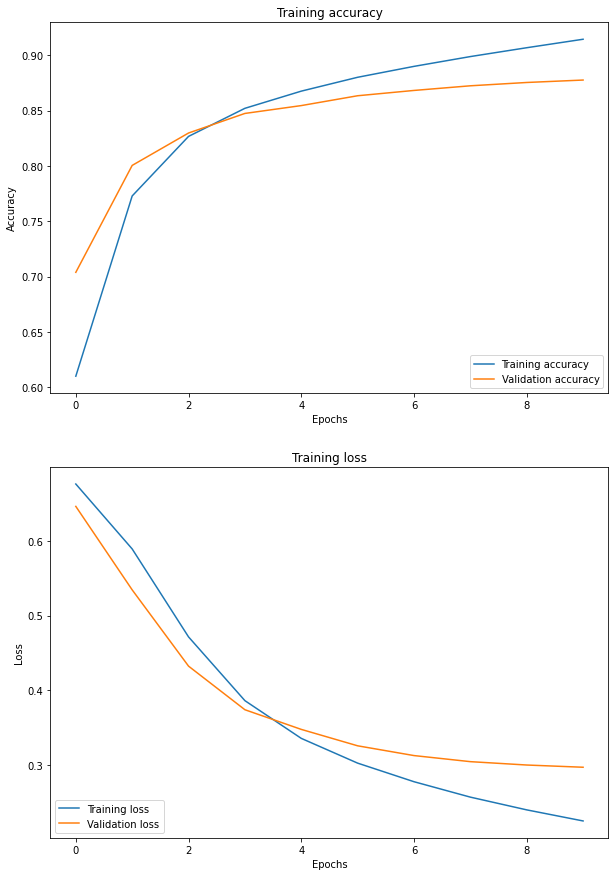

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].plot(acc_values, label="Training accuracy")
ax[0].plot(val_acc_values, label="Validation accuracy")
ax[0].set_title("Training accuracy")
ax[0].legend(loc='lower right')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_values, label="Training loss")
ax[1].plot(val_loss_values, label="Validation loss")
ax[1].set_title("Training loss")
ax[1].legend(loc='lower left')


As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient descent optimization — the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch.

This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is **overfitting**: after the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

We can evaluate the performance of the model on data it was never trained on - data the model has never seen before.

In [30]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.3018 - accuracy: 0.8760


[0.3018142879009247, 0.876039981842041]

We can also check the result of the model by making predictions on the test dataset, and then comparing the labels with the predictions.

In [31]:
np.set_printoptions(precision=6, suppress=True)
prediction = model.predict(x_test[:20])

print(np.column_stack((y_test[:20], prediction)))

[[0.       0.236235]
 [1.       0.999739]
 [1.       0.653339]
 [0.       0.654755]
 [1.       0.950741]
 [1.       0.806494]
 [1.       0.974294]
 [0.       0.009982]
 [0.       0.963893]
 [1.       0.952736]
 [1.       0.901621]
 [0.       0.005927]
 [0.       0.0014  ]
 [0.       0.0414  ]
 [1.       0.993299]
 [0.       0.003138]
 [1.       0.985872]
 [0.       0.492358]
 [0.       0.014987]
 [0.       0.133965]]
